# Examples PLATOSim Contamination

In [1]:
from contamination import Star, Planet, Transit, StarConfiguration, LightCurve, PhotometryData
from filters import Filter, filterP, filterR, filterB
from platosim.simulation import Simulation
import math
import numpy as np
import matplotlib.pyplot as plt

## Filters and Stars
PLATOSim Contamination allows working with different passbands or filters. A filter is stored in the `Filter` class. A custom filter can be made by passing a function returing the photon conversion efficiency for each wavelength. The passbands used by PLATO are already available as
- `filterP` : normal cameras
- `filterB` : fast camera with blue filter
- `filterR` : fast camera with red filter


Stars are stored in the `Star` class and are created by giving the star's effective temperature and its magnitude along with the filter in which this magnitude is interpreted. By default the special value "visual" is used, which corresponds to a visual magnitude, as available from the PLATO star catalog. From these values, the magnitude in any other passband can be calculated using the blackbody model.

Some useful methods are listed below.

In [2]:
star1 = Star(6000, 7) # Effective temperature 6000K and visual magnitude 7
star2 = Star(4000, 8) # Effective temperature 4000K and visual magnitude 8

print(star1.getMagnitude(filterB))  # Magnitude in the blue bandpass
print(star1.getFlux(filterB))       # Flux in the blue bandpass, units correspond to values of PlatoSim
print(star1.getLdc(filterB))        # Calculate limb darkening coefficients in the blue bandpass

7.0472834074174235
905679.605355227
(0.6731803968277335, 0.08738841241094451)


## Planets and Transits
A `Planet` object represents a planet with the following set of parameters:
- k : ratio between planet radius and host star radius
- t0 : time at the middle of the transit
- p : orbital period
- a: semi-long axis divided by radius host star
- i: inclination angle (radians)
- e : eccentricity
- w : periastron argument

In [3]:
myPlanet = Planet(**{
        "k": 0.05,           # Radius ratio
        "t0": 2.5,  # Time in the middle of the transit (h)
        "p": 3*24,    # Orbit period (hours)
        "a": 10,          # Semi major-axis
        "i": np.pi/2,       # inclination
        "e": 0,
        "w": 0
    })

A `Transit` object consists of a planet and its host star. The `getFlux()` method allows you to calculate the lightcurve for a given set of timepoints in a certain passband using PyTransit. The baselevel flux and the limb darkening coefficients are calculated from the host star. You can also request the normalised flux with `getFluxNorm()` and the difference in magnitude between the points in the transit and the baselevel with `getDeltaMag()`. There is also an option to write the deltaMag values to a file using `writeToFile()`. The timeseries is multiplied by 3600 in this case, since PyTransit usually works with hours.

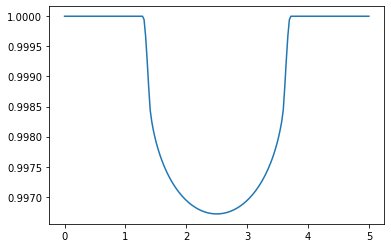

In [4]:
myTransit = Transit(star1, myPlanet)
time = np.linspace(0, 5, 200)
flux = myTransit.getFluxNorm(time, filterB) # Normalised flux
plt.plot(time, flux)

## Modelling contamination
The main reason this package was developed, is to model flux contamination. This can be done with the ´StarConfiguration´ class. A `StarConfiguration` object consists of a list of stars and a list of transits. The total flux is obtained by summing over all star fluxes including transits. Order of transits does not matter, since the `Transit` object allready contains its host star. It is required however, that all transit host stars are also in the stars list.

The flux can be requested with `getContaminatedFlux()`, and the normalised version with `getContaminatedFluxNorm()`. The baselevel, i.e. the flux when no transit is taking place, can be requested with `getContaminatedBaseFlux()`.

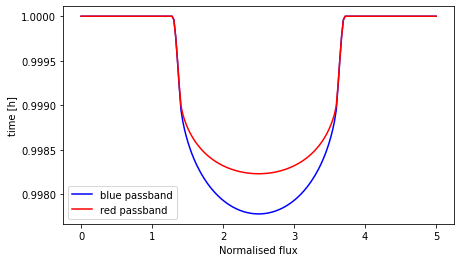

In [5]:
# star1 undergoing transit, star2 contaminating the flux
config = StarConfiguration([star1, star2], [myTransit])
fluxBlue = config.getContaminatedFluxNorm(time, filterB)
fluxRed = config.getContaminatedFluxNorm(time, filterR)
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# First plot: both fluxes
ax.plot(time, fluxBlue, color="blue", label="blue passband")
ax.plot(time, fluxRed, color="red", label="red passband")
ax.set_xlabel("Normalised flux")
ax.set_ylabel("time [h]")
ax.legend()

The effects of contamination can clearly be observed here

## Setting up a simulation
PLATOSim Contamination also makes it easy to setup a PLATOSim simulation for a given configuration of stars and transits. Calling the method `setupSimulation()` on a `StarConfiguration` will generate the necessary files and point the simulation object to them. The parameters are
- sim: the simulation object that will be set up
- numExp: the number of exposures that will be simulated
- passband: the passband in which magnitudes will be calculated
- appendix: string appended to filenames to distinguish between passbands (or other simulations)
- path: folder in which files will be stored

In [6]:
name = "test simulation"
configFile = "./inputfiles/inputfile.yaml"
outputFolder = "./output"  # Output files of the simulator
tempFolder = "./temp"
numFrames = 1440*5
simFiles = []
for band, appendix in zip([filterB, filterR], ["B", "R"]):
    sim = Simulation(name + appendix, configurationFile=configFile, outputDir=outputFolder, debug=False)
    
    config.setupSimulation(sim, numFrames, band, appendix, tempFolder)
    
    # Other parameters not set by setupSimulation()
    quarter = 0
    numColSubfield = 20
    numRowSubfield = 20
    # Solar panel orientation: 0, 90, 180, and 270 degrees for Q1, Q2, Q3, and Q4
    solarPanelOrientation = sim["Platform/SolarPanelOrientation"] = math.fmod(quarter * 90., 360.)
    solarPanelOrientation = np.deg2rad(float(solarPanelOrientation))
    # Set fields size
    sim["SubField/NumRows"] = numColSubfield
    sim["SubField/NumColumns"] = numRowSubfield

    sim["SubField/ZeroPointRow"]    = 0
    sim["SubField/ZeroPointColumn"] = 0
    

    print('-----------Running------------')
    simFile = sim.run(removeOutputFile=True, logLevel=3) #SIMULATION
    simFiles.append(simFile)
    print('-------Simulation ended-------')

-----------Running------------

2021-12-08 14:59:16 WARNING Camera: No point-like ghost positions to write to HDF5 file.

-------Simulation ended-------
-----------Running------------

2021-12-08 14:59:46 WARNING Camera: No point-like ghost positions to write to HDF5 file.

-------Simulation ended-------


## Reading and fitting data
A lightcurve generate by PlatoSim (or a real one) can be stored in a `LightCurve` object. A lightcurve object can be created by passing an array of timepoints with an array of fluxes, or can be created from a simulation object using `LightCurve.fromSimFile()` and passing the ID of the star (usually 0). The `lightcurve` object automatically calculated the standard deviations based on the Poisson distribution, with an extra correction applied.

A lightCurve object can be used to to fit a theoretical transit to the data with `fitTransit()`. A host star and guess planet are required. If `pandas` is set to True, the result is a DataFrame, otherwise it is a numpy matrix containing values in the first column and errors in the second.

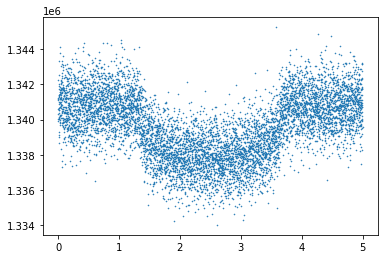

In [7]:
lcB = LightCurve.fromSimFile(simFiles[0], 0)
plt.scatter(lcB.times, lcB.flux, s=0.3)

In the case where there is no contamination, a fit can be made directly from a lightcurve. When there is contamination however, this needs to be taken into account.

For this purpose, the class `PhotometryData` can be used. A `PhotometryData` object contains the lightcurves of all passbands, along with all the stars that are adding flux. The object can be created by passing a list of stars with a list of `LightCurve` objects and passbands, or using `fromSimFiles()`.

When the host star of the observed transit is known, the class can fit a transit to the data using `fitAll()`, taking into account the fluxes in all passbands at the same time. Currently this only support a single transit occuring at a time.

An important issue that is often observed is the baseflux predicted by adding the star fluxes not agreeing with the data. While the reason for this is still unclear, a workaround is to specify a timeinterval in which no transit is occuring, a taking the mean flux in this interval as the baselevel. This interval is specified in `baseInterval`

In [8]:
data = PhotometryData.fromSimFiles([star1, star2], simFiles, 0, [filterB, filterR], baseInterval=(0, 1))

# Making the fits
guessPlanet = Planet(**{
    "k": 0.08,         # Radius ratio
    "t0": 2.5,         # Time in the middle of the transit (h)
    "p": 3*24,       # Orbit period (hours)
    "a": 15,           # Semi major-axis
    "i": np.pi/2,
    "e": 0,
    "w":0
})

params = data.fitAll(star1, guessPlanet, pandas=True)
display(params)

fittedTransit1 = Transit(star1, Planet(*params.value))

/home/ragnar/miniconda3/envs/platosim/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/ragnar/miniconda3/envs/platosim/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Least squares value: 14614.308
Reduced Least squares: 1.015
p-value: 0.09854


/home/ragnar/miniconda3/envs/platosim/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


,value,error
k,0.050299,0.000156
t0,2.500164,0.003400
p,74.967566,0.227459
a,10.333618,0.031258
i,1.569816,0.003051
e,0.000000,0.000000
w,0.000000,0.000000


We can use a `StarConfiguration` to compare the fitted values to the data. This can be done easily with `configurationFromFit()`.

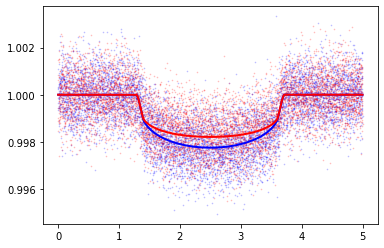

In [9]:
fitConfig = data.configurationFromFit(star1, params.value)

fig, ax = plt.subplots()
time = data.times
fluxB = data.getFluxData(filterB)
fluxR = data.getFluxData(filterR)
modelB = fitConfig.getContaminatedFlux(time, filterB)
modelR = fitConfig.getContaminatedFlux(time, filterR)
# Normalisation constants
maxB = np.max(modelB)
maxR = np.max(modelR)
ax.scatter(data.times, fluxB/maxB, color="blue", s=0.5, alpha=0.2)
ax.scatter(data.times, fluxR/maxR, color="red", s=0.5, alpha=0.2)

ax.plot(time, modelB/maxB, color="blue", linewidth=2)
ax.plot(time, modelR/maxR, color="red", linewidth=2)

## Determing transit host
In the real world is it usually unknown which star is the host of the observed transit. In the case of two possible host stars, the correct host star can be determined by making two different fits. One fit where star1 is assumed to be the host star, such as done above, and one fit where star2 is assumed to be the host star. The host star can then be determined by selecting the fi that corresponds best to data. Quantitatively, the best fit can be determined by performing a likelihood ration test. This is implemented in the method `getLikelihoodRatio`, where the two fitresults are given as transit objects. 

In [10]:
# Making the second fit
guessPlanet = Planet(**{
    "k": 0.08,         # Radius ratio
    "t0": 2.5,         # Time in the middle of the transit (h)
    "p": 3*24,       # Orbit period (hours)
    "a": 15,           # Semi major-axis
    "i": np.pi/2,
    "e": 0,
    "w":0
})

params = data.fitAll(star2, guessPlanet, pandas=True) # Use star2 as assumed host
display(params)

fittedTransit2 = Transit(star2, Planet(*params.value))

/home/ragnar/miniconda3/envs/platosim/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Least squares value: 17016.529
Reduced Least squares: 1.182
p-value: 0.0


,value,error
k,0.057493,7.771561e-17
t0,2.466075,1.243450e-13
p,91.312745,1.242797e-06
a,11.979327,2.193907e-10
i,1.561369,1.332268e-15
e,0.000000,0.000000e+00
w,0.000000,0.000000e+00


In [11]:
# Calculating likelihood ratio
alpha = .05
logRatio, p1, p2 = data.getLikelihoodRatio(fittedTransit1, fittedTransit2)
print("alpha = " + str(alpha))
print()
print("c = ln(ratio) = " + str(round(logRatio, 1)))
print("p-value star1 = " + str(round(p1, 3)))
print("p-value star2 = " + str(round(p2, 3)))
if p2 < 0.05:
    result = "star 1"
elif p1 < 0.05:
    result = "star 2"
else:
    result = "uncertain"
print("---> " + result)

alpha = 0.05

c = ln(ratio) = 1239.4
p-value star1 = 0.785
p-value star2 = 0.0
---> star 1


These values need to be interpreted in the following way. $c$ is equal to
$$c = ln(\Lambda) = ln(\frac{\mathcal{L}(D | H_1)}{\mathcal{L}(D | H_2)}).$$
Where $\mathcal{L}(D | H_2)$ is the likelihood of getting the observed data assuming star1 is the transit host, and $\mathcal{L}(D | H_2)$ is the likelihood of getting the data assuming star2 is host. If this value is positive, this indicates star1 is more likely to be the host and if it is negative it is more likely for star2 to be the host.

The meaning of the p-values is:
$$p_1 = P(ln(\Lambda) < c | H_1)$$
$$p_2 = P(ln(\Lambda) < c | H_2)$$

Thus, $p_1$ equals the probability that $ln(\Lambda)$, is smaller than the observed value c, assuming our data is distributed in accordance with model1, i.e. star1 is the host and the fitted parameters are correct.

If $p_1 < \alpha$ for a chosen significance value $\alpha$, $H_1$ will be rejected, and thus it can be stated with certainty $\alpha$ that star2 is the host star. Conversely, if $p_2 < \alpha$ it can be stated that star1 is the host. If neither of these are true, no statements can be made on a significance level $\alpha$